In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM



Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


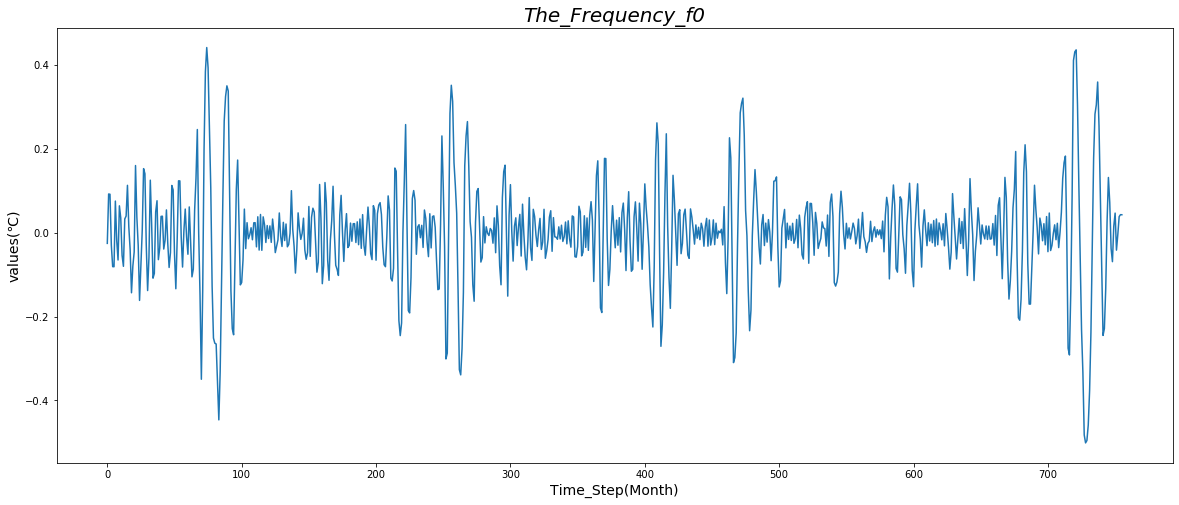

(708, 24, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 16s - loss: 0.0139
Epoch 2/200
 - 9s - loss: 0.0139
Epoch 3/200
 - 9s - loss: 0.0137
Epoch 4/200
 - 9s - loss: 0.0137
Epoch 5/200
 - 9s - loss: 0.0137
Epoch 6/200
 - 9s - loss: 0.0136
Epoch 7/200
 - 9s - loss: 0.0135
Epoch 8/200
 - 9s - loss: 0.0130
Epoch 9/200
 - 9s - loss: 0.0130
Epoch 10/200
 - 9s - loss: 0.0131
Epoch 11/200
 - 9s - loss: 0.0124
Epoch 12/200
 - 9s - loss: 0.0124
Epoch 13/200
 - 9s - loss: 0.0124
Epoch 14/200
 - 9s - loss: 0.0123
Epoch 15/200
 - 9s - loss: 0.0117
Epoch 16/200
 - 9s - loss: 0.0115
Epoch 17/200
 - 9s - loss: 0.0116
Epoch 18/200
 - 9s - loss: 0.0112
Epoch 19/200
 - 9s - loss: 0.0117
Epoch 20/200
 - 9s - loss: 0.0114
Epoch 21/200
 - 9s - loss: 0.0109
Epoch 22/200
 - 9s - loss: 0.0109
Epoch 23/200
 - 9s - loss: 0.0116
Epoch 24/200
 - 9s - loss: 0.0112
Epoch 25/200
 - 9s - loss: 0.0114
Epoch 26/200
 - 9s - loss

(60, 12)


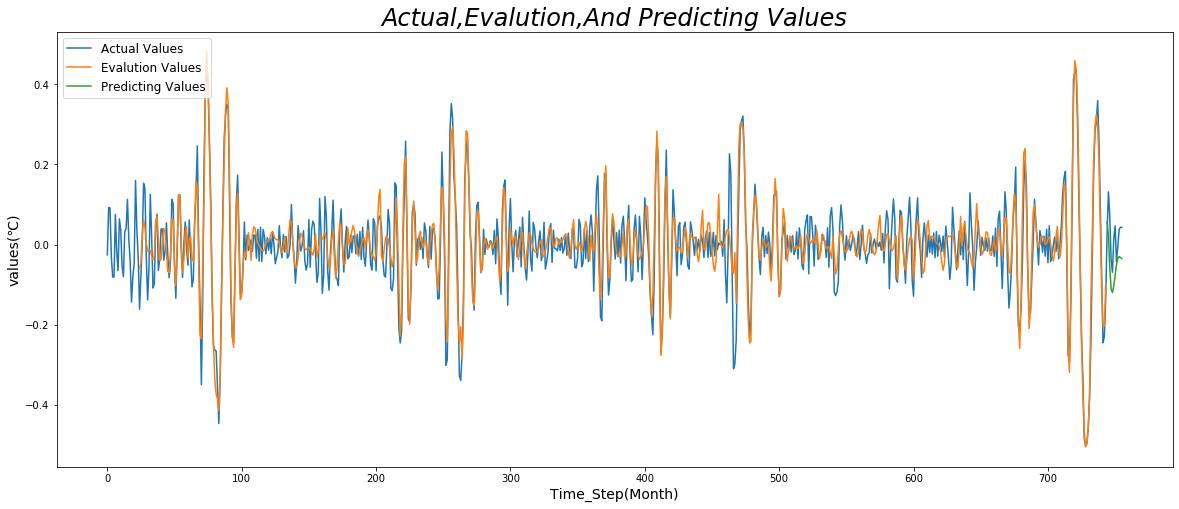

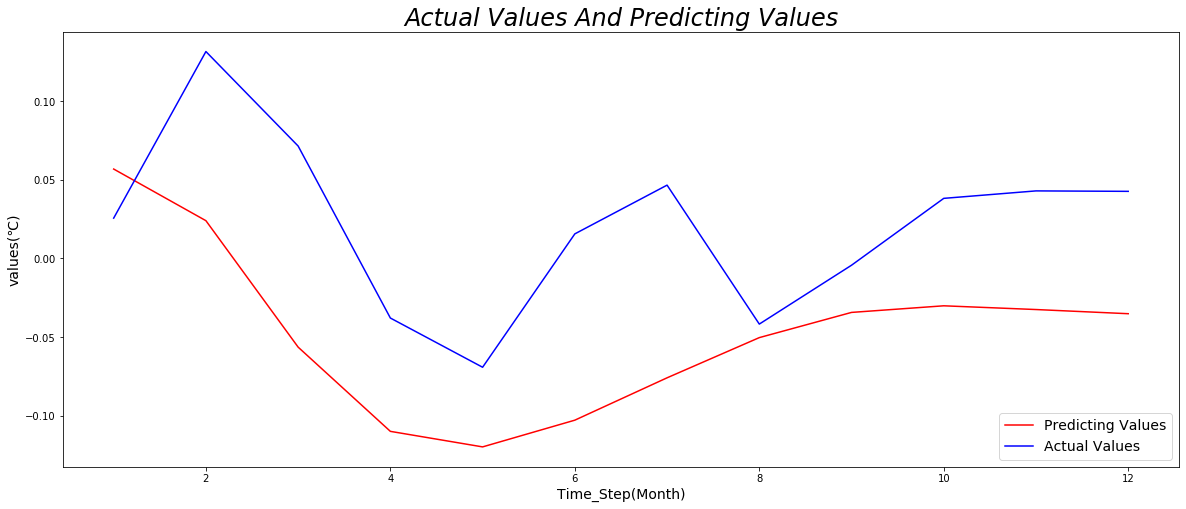

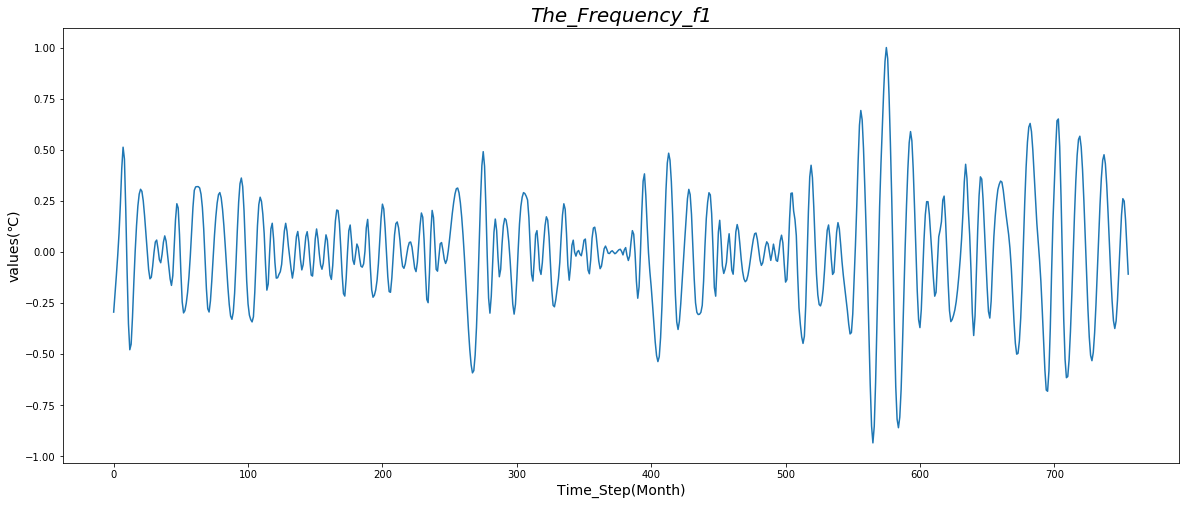

(708, 24, 1)
Epoch 1/200
 - 18s - loss: 0.0657
Epoch 2/200
 - 9s - loss: 0.0586
Epoch 3/200
 - 9s - loss: 0.0529
Epoch 4/200
 - 9s - loss: 0.0460
Epoch 5/200
 - 9s - loss: 0.0452
Epoch 6/200
 - 9s - loss: 0.0424
Epoch 7/200
 - 9s - loss: 0.0495
Epoch 8/200
 - 9s - loss: 0.0427
Epoch 9/200
 - 9s - loss: 0.0409
Epoch 10/200
 - 9s - loss: 0.0381
Epoch 11/200
 - 9s - loss: 0.0395
Epoch 12/200
 - 9s - loss: 0.0366
Epoch 13/200
 - 9s - loss: 0.0374
Epoch 14/200
 - 9s - loss: 0.0351
Epoch 15/200
 - 9s - loss: 0.0340
Epoch 16/200
 - 9s - loss: 0.0337
Epoch 17/200
 - 9s - loss: 0.0336
Epoch 18/200
 - 9s - loss: 0.0331
Epoch 19/200
 - 9s - loss: 0.0329
Epoch 20/200
 - 9s - loss: 0.0335
Epoch 21/200
 - 9s - loss: 0.0311
Epoch 22/200
 - 9s - loss: 0.0336
Epoch 23/200
 - 9s - loss: 0.0299
Epoch 24/200
 - 9s - loss: 0.0295
Epoch 25/200
 - 9s - loss: 0.0306
Epoch 26/200
 - 9s - loss: 0.0294
Epoch 27/200
 - 9s - loss: 0.0295
Epoch 28/200
 - 9s - loss: 0.0294
Epoch 29/200
 - 9s - loss: 0.0298
Epoch 30/

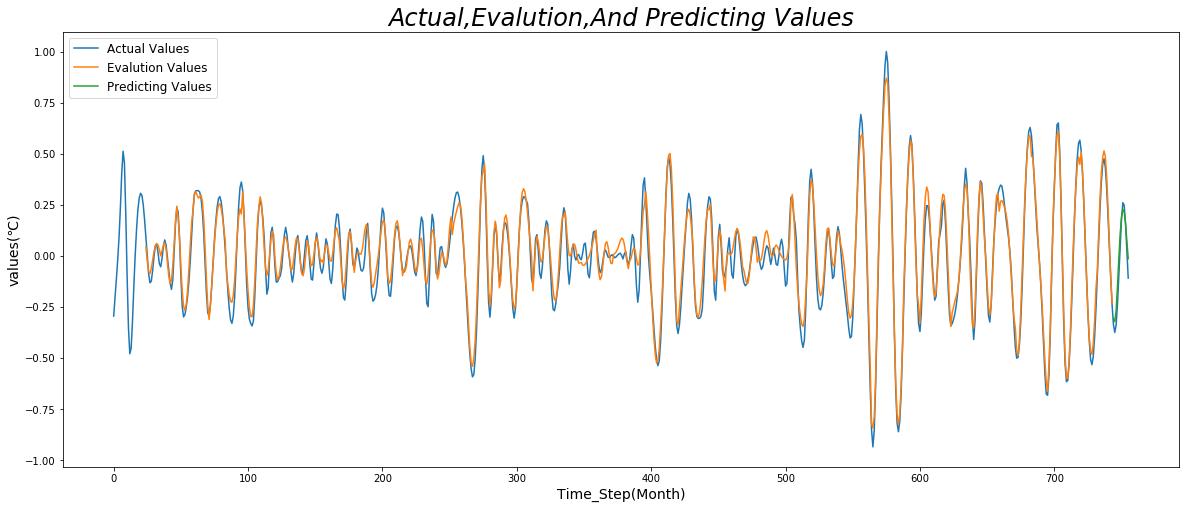

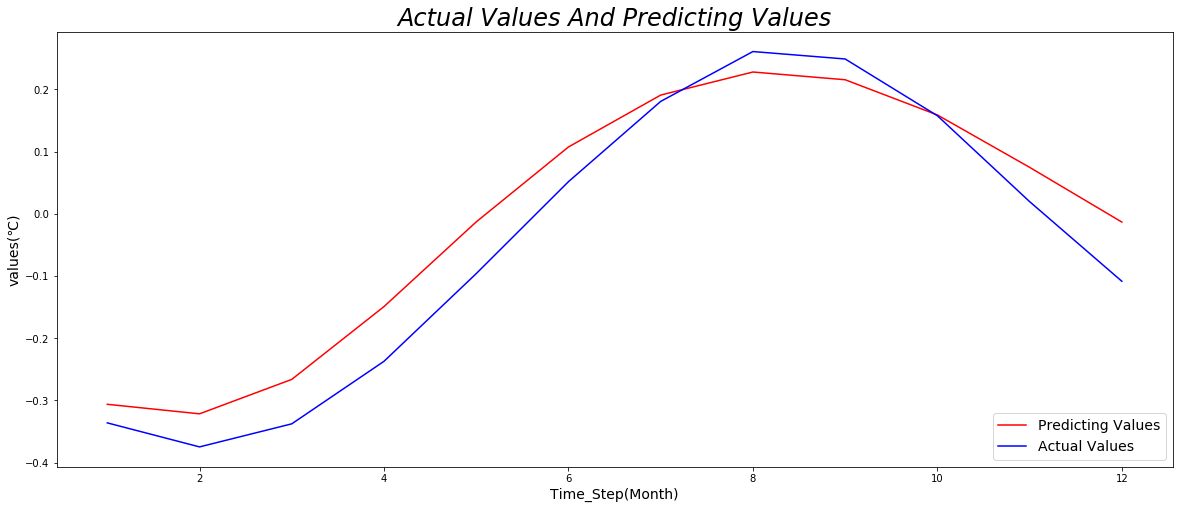

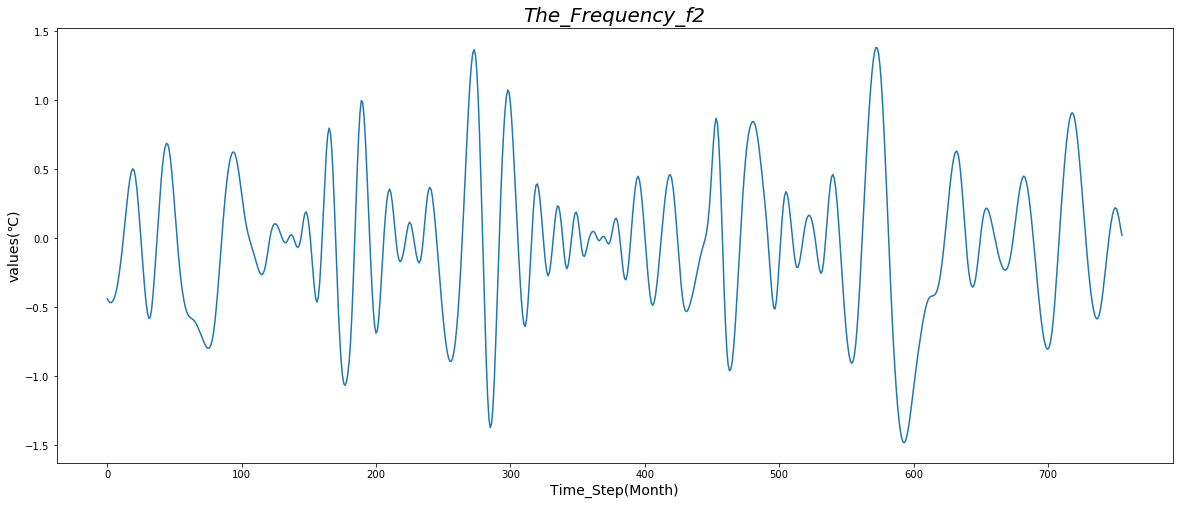

(708, 24, 1)
Epoch 1/200
 - 19s - loss: 0.2529
Epoch 2/200
 - 9s - loss: 0.2490
Epoch 3/200
 - 10s - loss: 0.2347
Epoch 4/200
 - 9s - loss: 0.2151
Epoch 5/200
 - 10s - loss: 0.1781
Epoch 6/200
 - 10s - loss: 0.1439
Epoch 7/200
 - 10s - loss: 0.1485
Epoch 8/200
 - 10s - loss: 0.1294
Epoch 9/200
 - 9s - loss: 0.1104
Epoch 10/200
 - 10s - loss: 0.1049
Epoch 11/200
 - 9s - loss: 0.1090
Epoch 12/200
 - 9s - loss: 0.0948
Epoch 13/200
 - 9s - loss: 0.0881
Epoch 14/200
 - 9s - loss: 0.0859
Epoch 15/200
 - 9s - loss: 0.0825
Epoch 16/200
 - 9s - loss: 0.0842
Epoch 17/200
 - 9s - loss: 0.0829
Epoch 18/200
 - 9s - loss: 0.0889
Epoch 19/200
 - 9s - loss: 0.0729
Epoch 20/200
 - 5s - loss: 0.0736
Epoch 21/200
 - 5s - loss: 0.0654
Epoch 22/200
 - 5s - loss: 0.0698
Epoch 23/200
 - 5s - loss: 0.0658
Epoch 24/200
 - 5s - loss: 0.0705
Epoch 25/200
 - 5s - loss: 0.0588
Epoch 26/200
 - 5s - loss: 0.0588
Epoch 27/200
 - 5s - loss: 0.0742
Epoch 28/200
 - 5s - loss: 0.0612
Epoch 29/200
 - 5s - loss: 0.0577
Epo

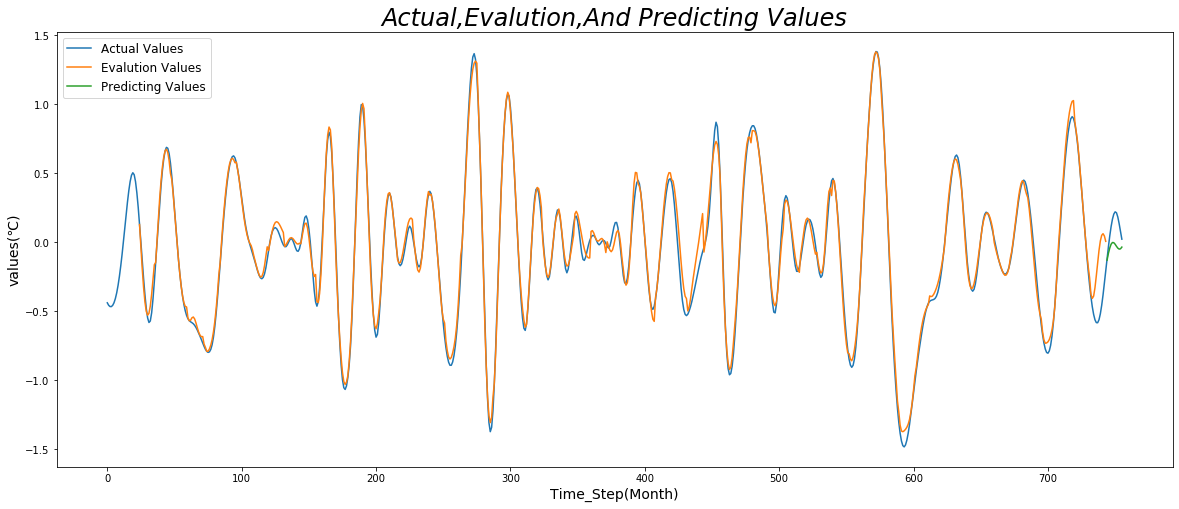

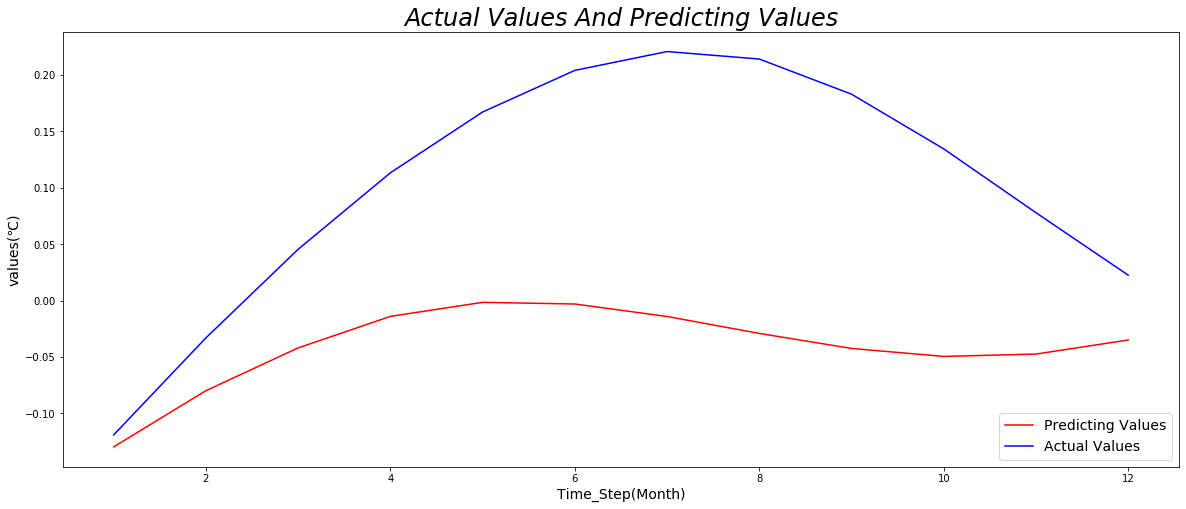

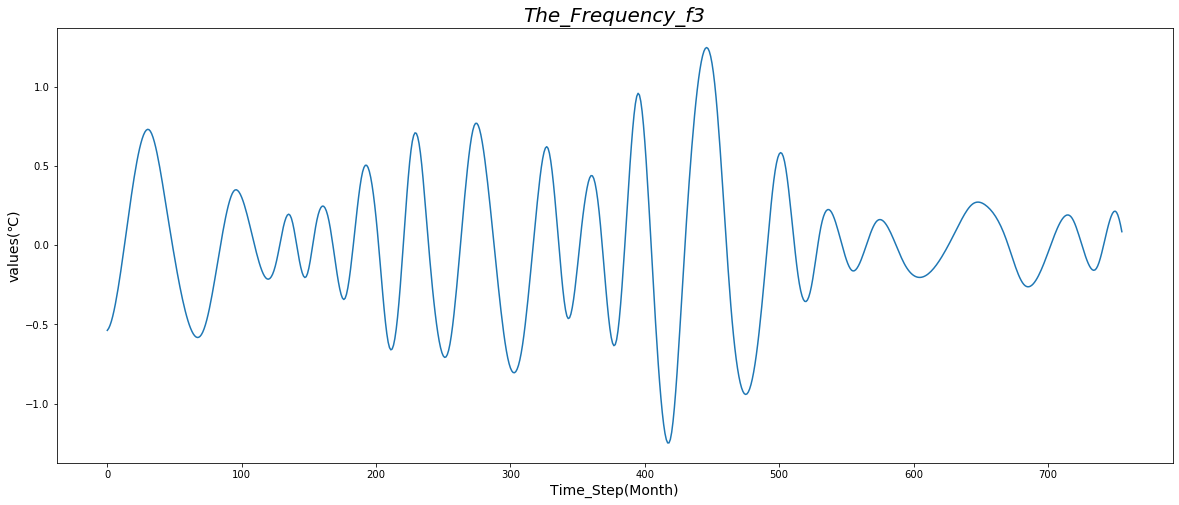

(708, 24, 1)
Epoch 1/200
 - 19s - loss: 0.1552
Epoch 2/200
 - 9s - loss: 0.1190
Epoch 3/200
 - 9s - loss: 0.0881
Epoch 4/200
 - 9s - loss: 0.0778
Epoch 5/200
 - 9s - loss: 0.0657
Epoch 6/200
 - 9s - loss: 0.0516
Epoch 7/200
 - 9s - loss: 0.0526
Epoch 8/200
 - 9s - loss: 0.0419
Epoch 9/200
 - 9s - loss: 0.0375
Epoch 10/200
 - 9s - loss: 0.0335
Epoch 11/200
 - 9s - loss: 0.0281
Epoch 12/200
 - 9s - loss: 0.0239
Epoch 13/200
 - 9s - loss: 0.0194
Epoch 14/200
 - 9s - loss: 0.0213
Epoch 15/200
 - 9s - loss: 0.0271
Epoch 16/200
 - 9s - loss: 0.0193
Epoch 17/200
 - 9s - loss: 0.0151
Epoch 18/200
 - 9s - loss: 0.0158
Epoch 19/200
 - 9s - loss: 0.0142
Epoch 20/200
 - 9s - loss: 0.0142
Epoch 21/200
 - 9s - loss: 0.0133
Epoch 22/200
 - 9s - loss: 0.0191
Epoch 23/200
 - 9s - loss: 0.0202
Epoch 24/200
 - 9s - loss: 0.0142
Epoch 25/200
 - 9s - loss: 0.0116
Epoch 26/200
 - 9s - loss: 0.0112
Epoch 27/200
 - 9s - loss: 0.0130
Epoch 28/200
 - 9s - loss: 0.0146
Epoch 29/200
 - 9s - loss: 0.0126
Epoch 30/

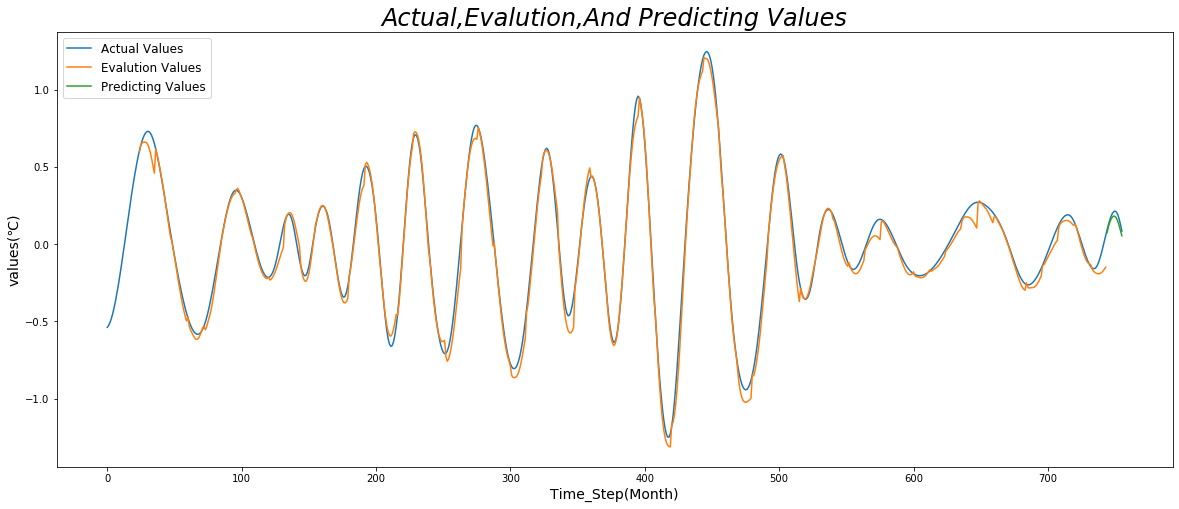

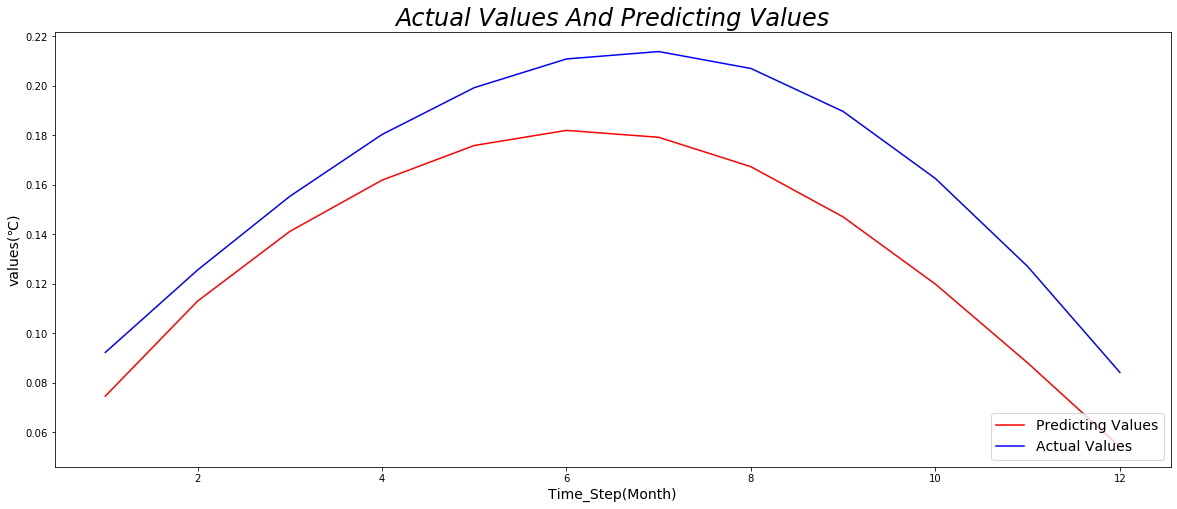

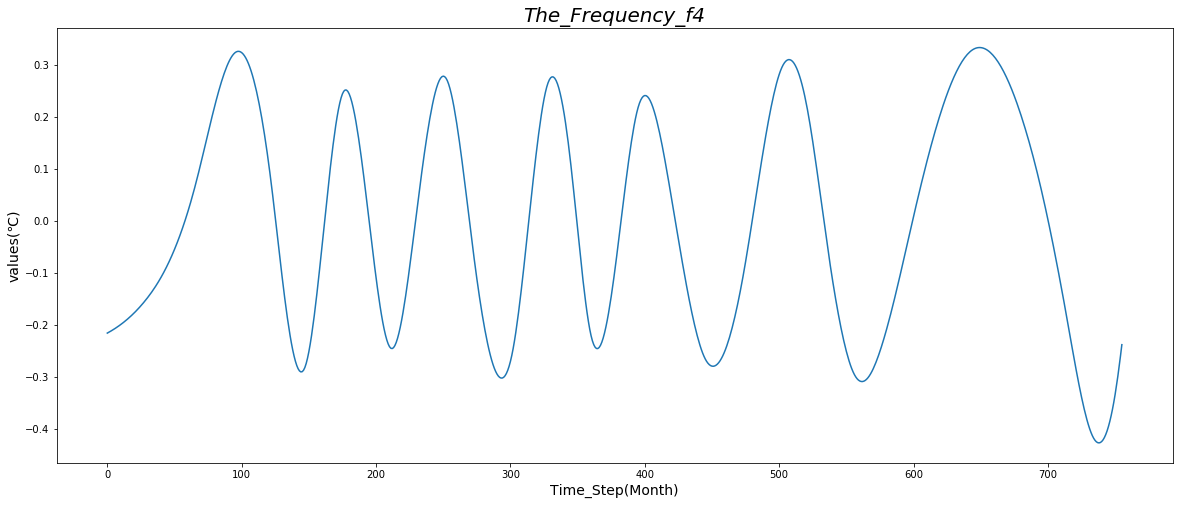

(708, 24, 1)
Epoch 1/200
 - 20s - loss: 0.0322
Epoch 2/200
 - 9s - loss: 0.0119
Epoch 3/200
 - 9s - loss: 0.0064
Epoch 4/200
 - 9s - loss: 0.0050
Epoch 5/200
 - 9s - loss: 0.0040
Epoch 6/200
 - 9s - loss: 0.0025
Epoch 7/200
 - 9s - loss: 0.0024
Epoch 8/200
 - 9s - loss: 0.0021
Epoch 9/200
 - 9s - loss: 0.0023
Epoch 10/200
 - 9s - loss: 0.0020
Epoch 11/200
 - 9s - loss: 0.0024
Epoch 12/200
 - 9s - loss: 0.0030
Epoch 13/200
 - 9s - loss: 0.0024
Epoch 14/200
 - 9s - loss: 0.0021
Epoch 15/200
 - 9s - loss: 0.0016
Epoch 16/200
 - 9s - loss: 0.0017
Epoch 17/200
 - 9s - loss: 0.0016
Epoch 18/200
 - 9s - loss: 0.0014
Epoch 19/200
 - 9s - loss: 0.0012
Epoch 20/200
 - 9s - loss: 0.0019
Epoch 21/200
 - 9s - loss: 0.0019
Epoch 22/200
 - 10s - loss: 0.0015
Epoch 23/200
 - 9s - loss: 0.0014
Epoch 24/200
 - 9s - loss: 0.0013
Epoch 25/200
 - 9s - loss: 0.0013
Epoch 26/200
 - 9s - loss: 0.0014
Epoch 27/200
 - 9s - loss: 0.0015
Epoch 28/200
 - 9s - loss: 0.0014
Epoch 29/200
 - 9s - loss: 0.0011
Epoch 30

(60, 12)


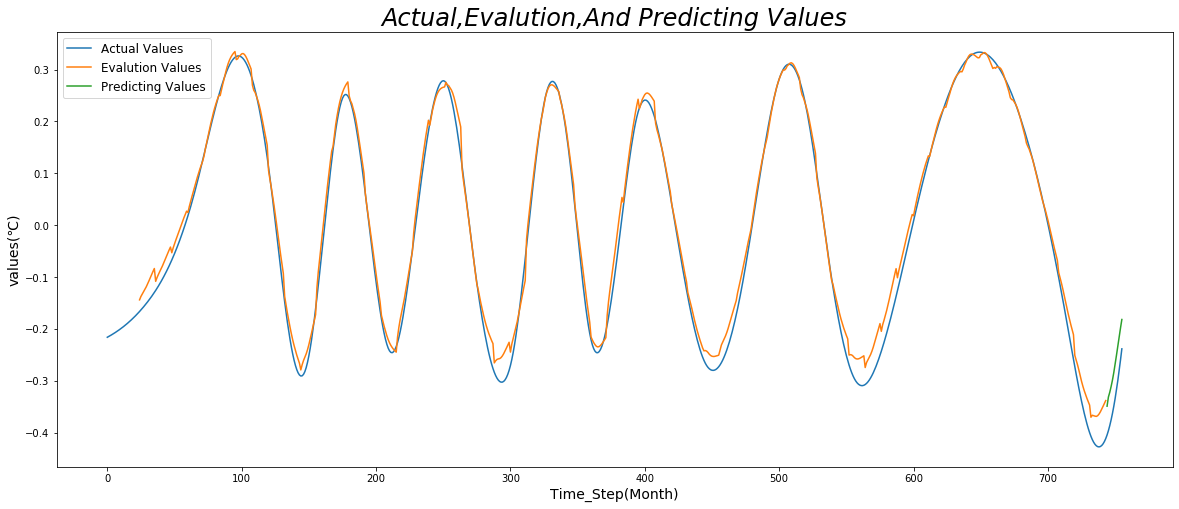

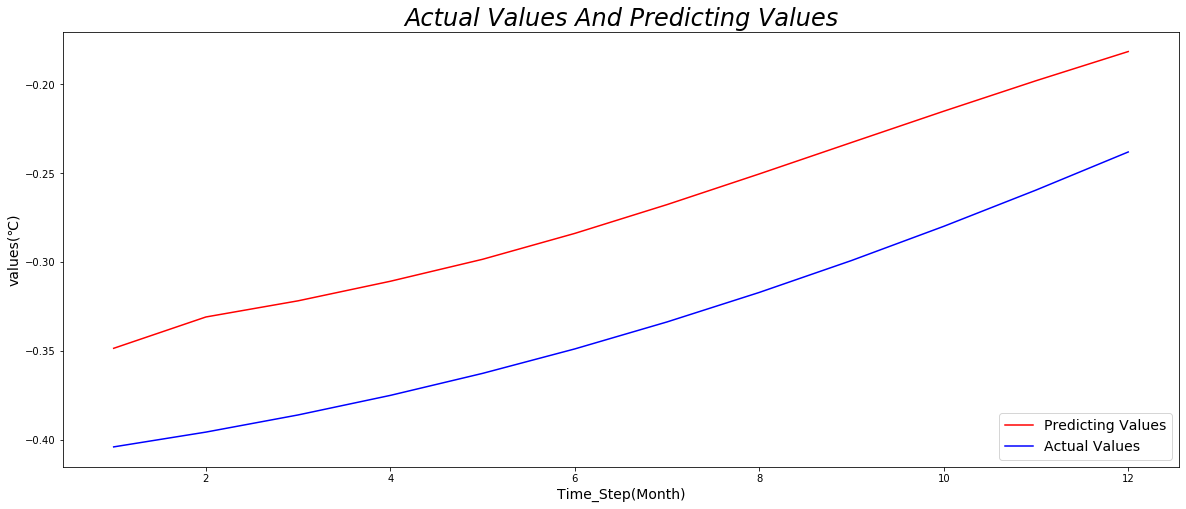

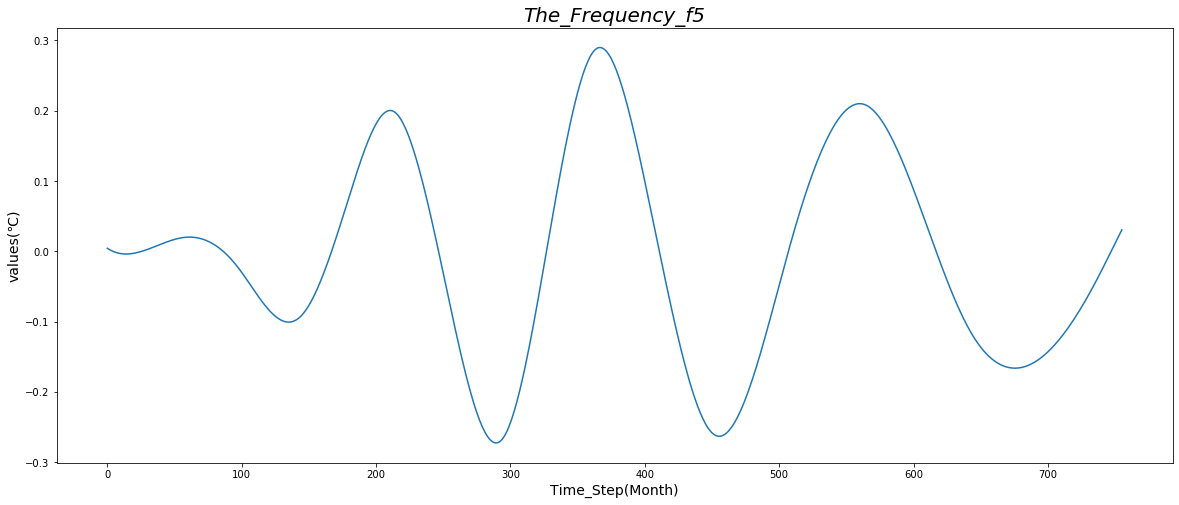

(708, 24, 1)
Epoch 1/200
 - 21s - loss: 0.0136
Epoch 2/200
 - 10s - loss: 0.0054
Epoch 3/200
 - 10s - loss: 0.0020
Epoch 4/200
 - 9s - loss: 0.0011
Epoch 5/200
 - 10s - loss: 7.4300e-04
Epoch 6/200
 - 9s - loss: 5.5862e-04
Epoch 7/200
 - 10s - loss: 4.9540e-04
Epoch 8/200
 - 10s - loss: 5.5876e-04
Epoch 9/200
 - 10s - loss: 4.4945e-04
Epoch 10/200
 - 9s - loss: 6.2180e-04
Epoch 11/200
 - 9s - loss: 6.0680e-04
Epoch 12/200
 - 10s - loss: 6.0031e-04
Epoch 13/200
 - 9s - loss: 4.3535e-04
Epoch 14/200
 - 10s - loss: 4.1129e-04
Epoch 15/200
 - 10s - loss: 3.9251e-04
Epoch 16/200
 - 9s - loss: 4.4118e-04
Epoch 17/200
 - 9s - loss: 4.2300e-04
Epoch 18/200
 - 9s - loss: 4.3338e-04
Epoch 19/200
 - 9s - loss: 3.9164e-04
Epoch 20/200
 - 9s - loss: 3.7025e-04
Epoch 21/200
 - 10s - loss: 3.4746e-04
Epoch 22/200
 - 9s - loss: 3.4728e-04
Epoch 23/200
 - 10s - loss: 3.2163e-04
Epoch 24/200
 - 9s - loss: 3.1279e-04
Epoch 25/200
 - 9s - loss: 4.7672e-04
Epoch 26/200
 - 9s - loss: 4.4586e-04
Epoch 27/200

(60, 12)


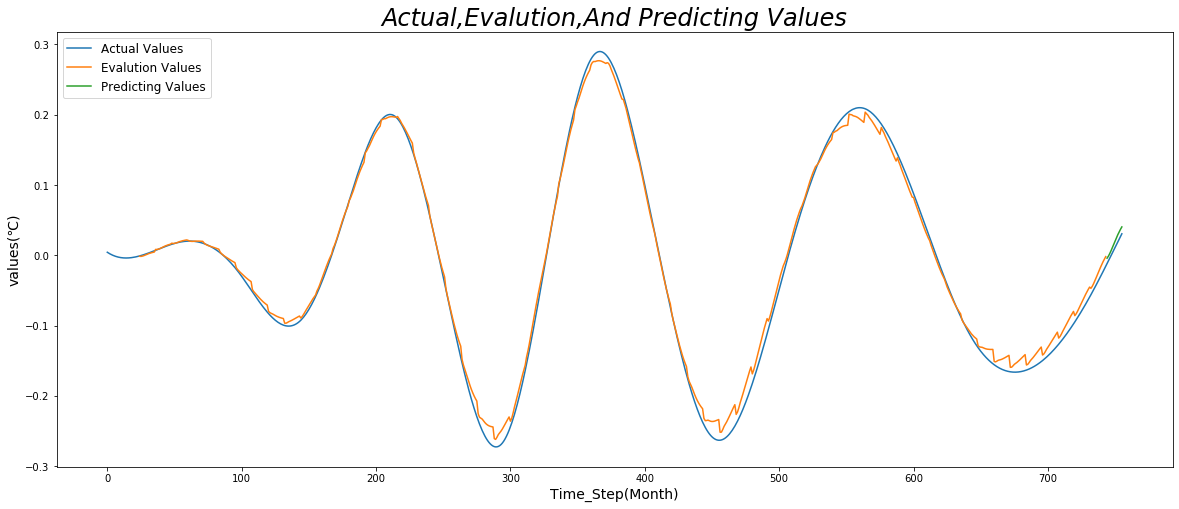

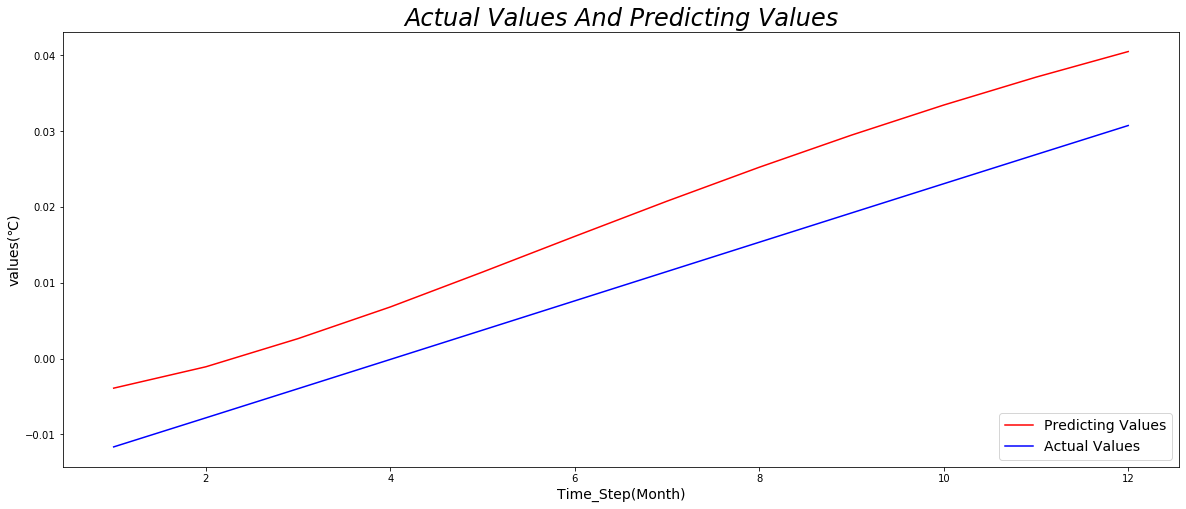

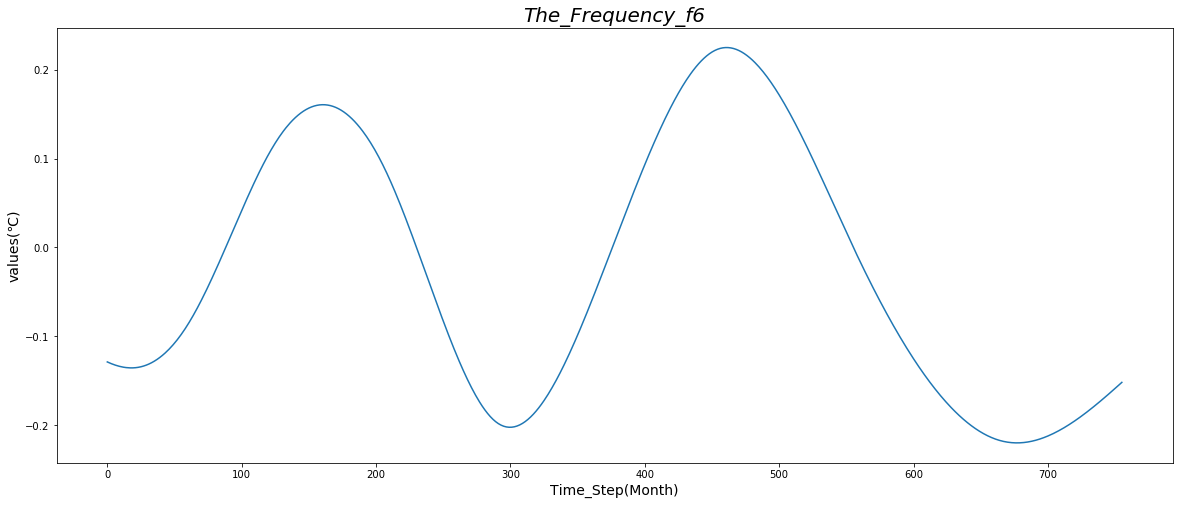

(708, 24, 1)
Epoch 1/200
 - 21s - loss: 0.0090
Epoch 2/200
 - 10s - loss: 0.0036
Epoch 3/200
 - 10s - loss: 0.0021
Epoch 4/200
 - 10s - loss: 0.0012
Epoch 5/200
 - 10s - loss: 5.9514e-04
Epoch 6/200
 - 10s - loss: 4.9453e-04
Epoch 7/200
 - 10s - loss: 4.2540e-04
Epoch 8/200
 - 10s - loss: 4.0289e-04
Epoch 9/200
 - 10s - loss: 3.9303e-04
Epoch 10/200
 - 10s - loss: 5.2447e-04
Epoch 11/200
 - 10s - loss: 4.0401e-04
Epoch 12/200
 - 10s - loss: 3.5637e-04
Epoch 13/200
 - 10s - loss: 2.9293e-04
Epoch 14/200
 - 10s - loss: 2.7237e-04
Epoch 15/200
 - 10s - loss: 3.1515e-04
Epoch 16/200
 - 10s - loss: 4.3691e-04
Epoch 17/200
 - 6s - loss: 3.4600e-04
Epoch 18/200
 - 6s - loss: 3.0625e-04
Epoch 19/200
 - 6s - loss: 3.3372e-04
Epoch 20/200
 - 5s - loss: 2.7869e-04
Epoch 21/200
 - 5s - loss: 2.4641e-04
Epoch 22/200
 - 5s - loss: 2.6780e-04
Epoch 23/200
 - 5s - loss: 3.1187e-04
Epoch 24/200
 - 5s - loss: 2.6497e-04
Epoch 25/200
 - 5s - loss: 2.4348e-04
Epoch 26/200
 - 6s - loss: 2.4887e-04
Epoch 27

(60, 12)


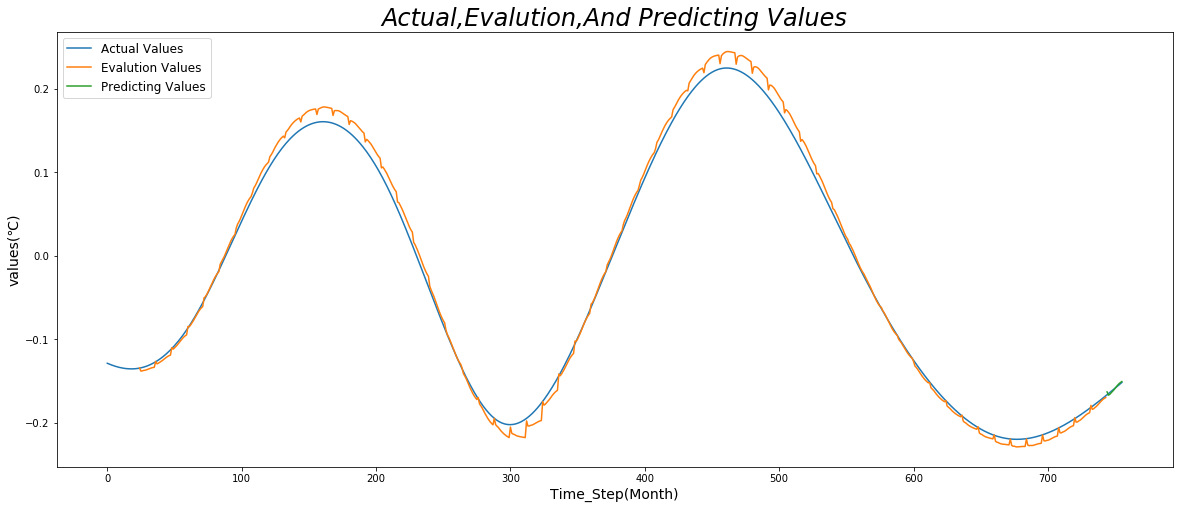

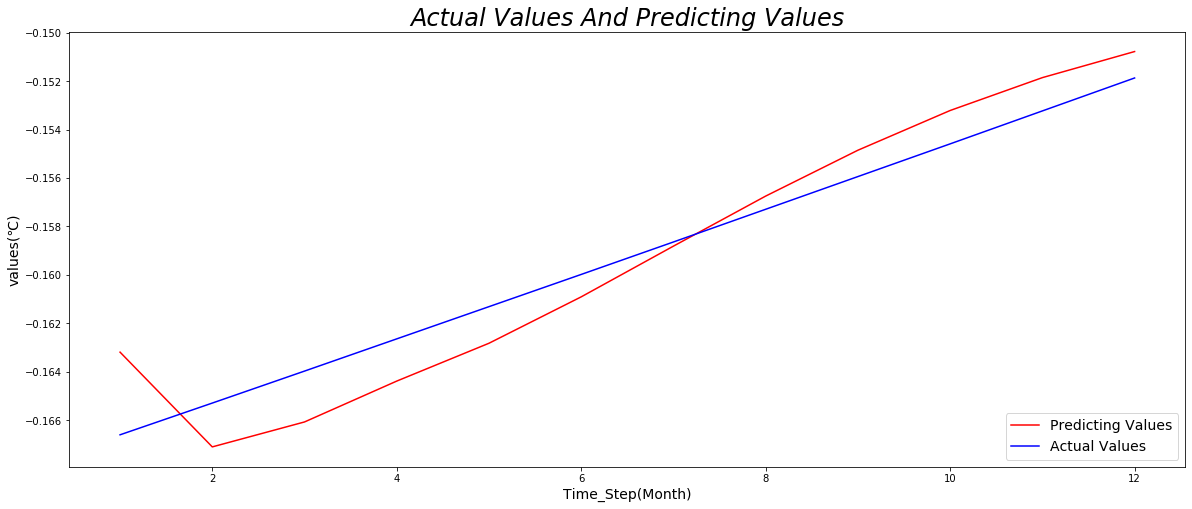

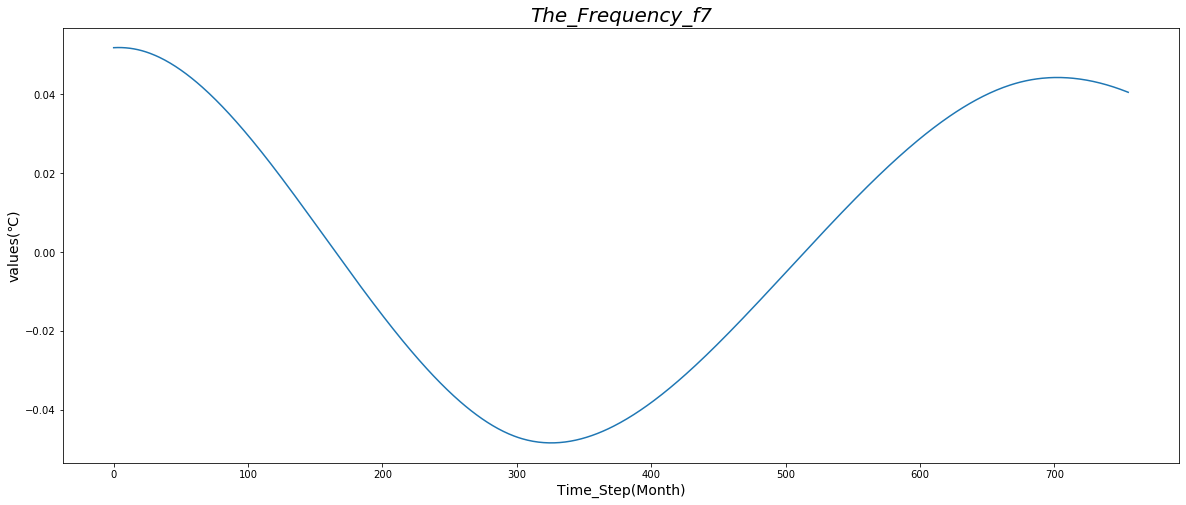

(708, 24, 1)
Epoch 1/200
 - 8s - loss: 6.6688e-04
Epoch 2/200
 - 5s - loss: 2.5772e-04
Epoch 3/200
 - 5s - loss: 1.6454e-04
Epoch 4/200
 - 5s - loss: 1.2564e-04
Epoch 5/200
 - 5s - loss: 8.9480e-05
Epoch 6/200
 - 5s - loss: 8.9607e-05
Epoch 7/200
 - 5s - loss: 6.9307e-05
Epoch 8/200
 - 5s - loss: 6.4298e-05
Epoch 9/200
 - 5s - loss: 5.7753e-05
Epoch 10/200
 - 5s - loss: 6.0531e-05
Epoch 11/200
 - 5s - loss: 4.7343e-05
Epoch 12/200
 - 5s - loss: 4.9130e-05
Epoch 13/200
 - 5s - loss: 4.5056e-05
Epoch 14/200
 - 5s - loss: 4.8229e-05
Epoch 15/200
 - 5s - loss: 4.1279e-05
Epoch 16/200
 - 5s - loss: 3.4057e-05
Epoch 17/200
 - 5s - loss: 2.9595e-05
Epoch 18/200
 - 5s - loss: 3.9739e-05
Epoch 19/200
 - 5s - loss: 4.5103e-05
Epoch 20/200
 - 5s - loss: 3.7591e-05
Epoch 21/200
 - 5s - loss: 2.9965e-05
Epoch 22/200
 - 5s - loss: 3.5597e-05
Epoch 23/200
 - 5s - loss: 2.6995e-05
Epoch 24/200
 - 5s - loss: 2.1022e-05
Epoch 25/200
 - 5s - loss: 2.1270e-05
Epoch 26/200
 - 5s - loss: 1.9591e-05
Epoch 27

(60, 12)


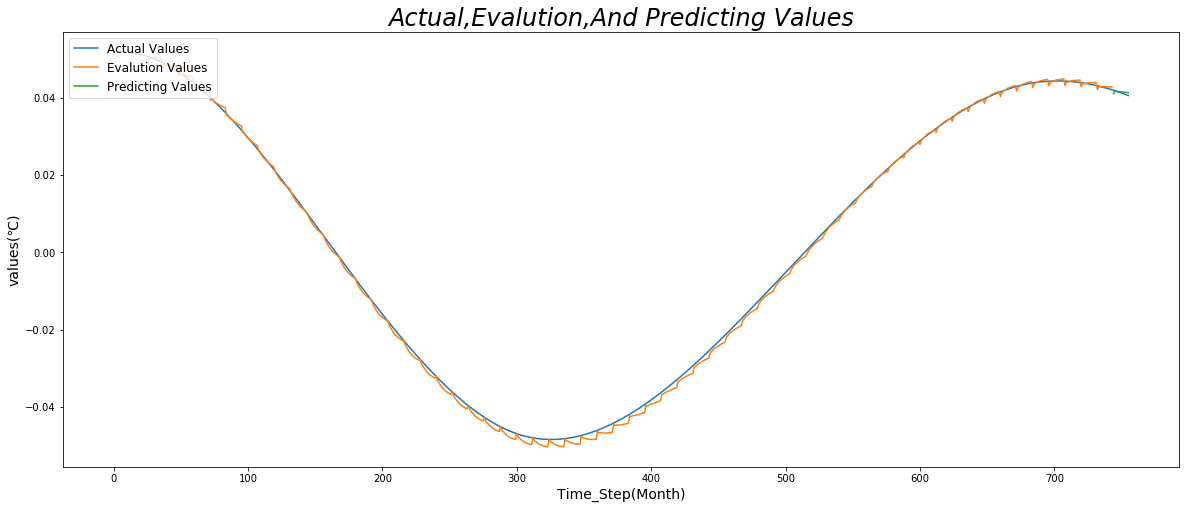

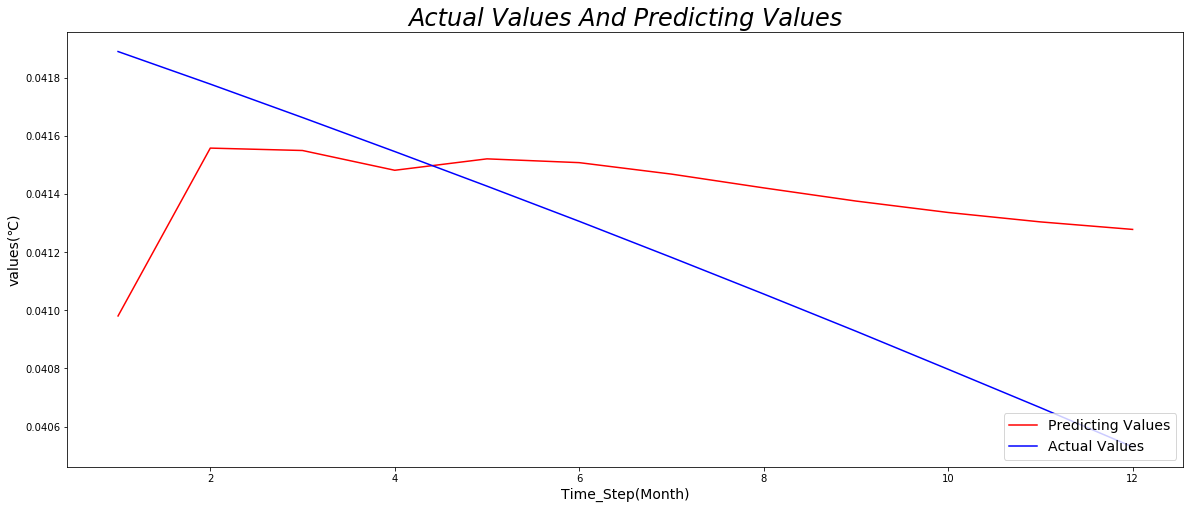

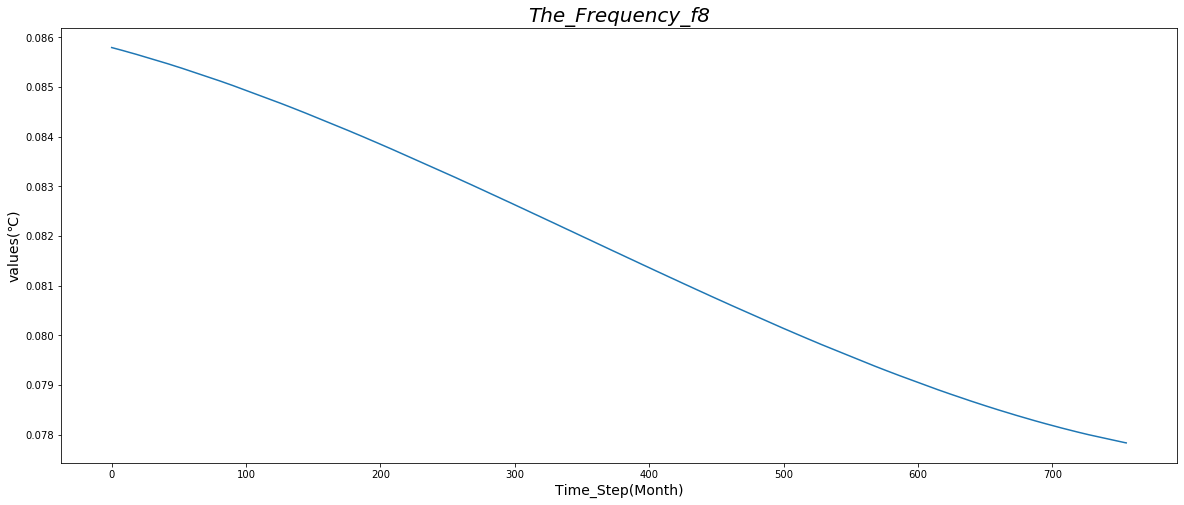

(708, 24, 1)
Epoch 1/200
 - 8s - loss: 5.8714e-04
Epoch 2/200
 - 5s - loss: 1.5921e-05
Epoch 3/200
 - 5s - loss: 7.9603e-06
Epoch 4/200
 - 5s - loss: 6.8619e-06
Epoch 5/200
 - 5s - loss: 7.0586e-06
Epoch 6/200
 - 5s - loss: 6.9951e-06
Epoch 7/200
 - 5s - loss: 6.3078e-06
Epoch 8/200
 - 5s - loss: 6.6567e-06
Epoch 9/200
 - 5s - loss: 6.1676e-06
Epoch 10/200
 - 5s - loss: 6.3756e-06
Epoch 11/200
 - 5s - loss: 6.3949e-06
Epoch 12/200
 - 5s - loss: 6.1394e-06
Epoch 13/200
 - 5s - loss: 6.1771e-06
Epoch 14/200
 - 5s - loss: 6.0238e-06
Epoch 15/200
 - 5s - loss: 6.6906e-06
Epoch 16/200
 - 5s - loss: 6.4154e-06
Epoch 17/200
 - 5s - loss: 5.9617e-06
Epoch 18/200
 - 5s - loss: 5.8224e-06
Epoch 19/200
 - 5s - loss: 6.1189e-06
Epoch 20/200
 - 5s - loss: 6.5079e-06
Epoch 21/200
 - 5s - loss: 5.9242e-06
Epoch 22/200
 - 5s - loss: 6.5739e-06
Epoch 23/200
 - 5s - loss: 5.8086e-06
Epoch 24/200
 - 5s - loss: 6.0461e-06
Epoch 25/200
 - 5s - loss: 6.0332e-06
Epoch 26/200
 - 6s - loss: 6.0160e-06
Epoch 27

(60, 12)


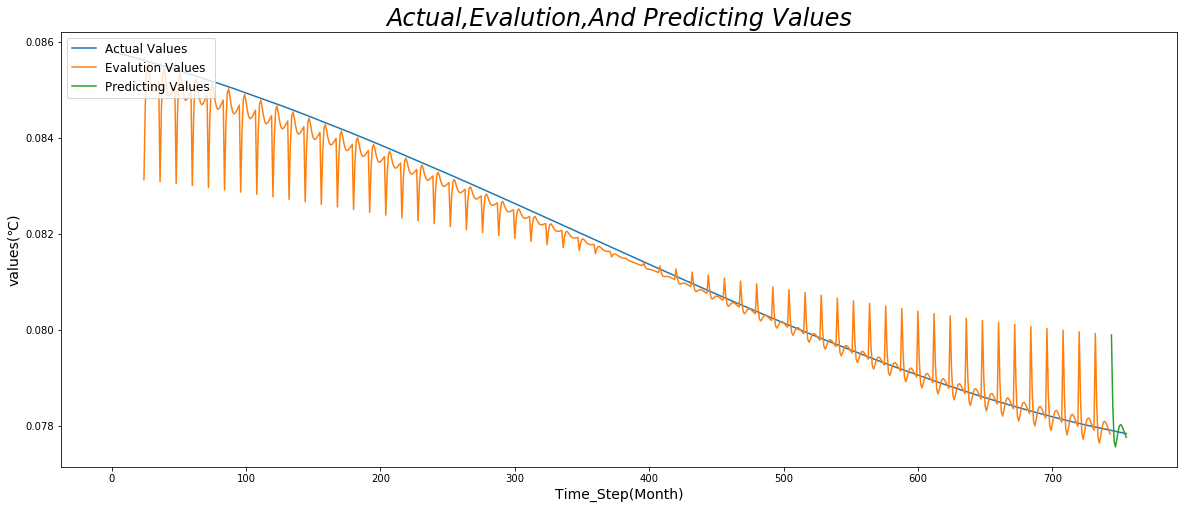

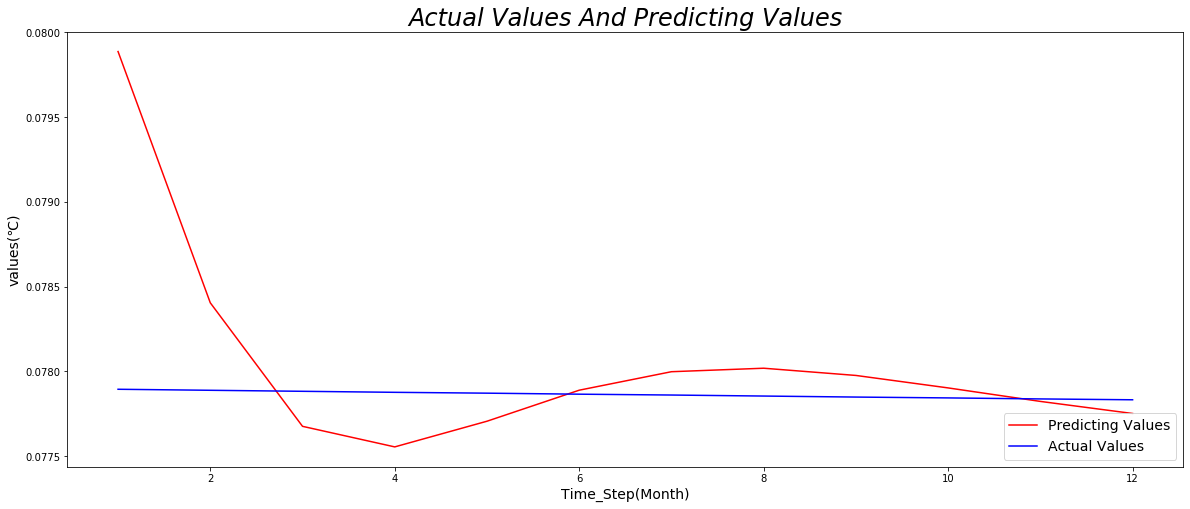

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-72]

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.07988698]
 [0.07840502]
 [0.07767641]
 [0.07755511]
 [0.07770652]
 [0.07788952]
 [0.07799856]
 [0.07801913]
 [0.07797652]
 [0.07790297]
 [0.07782338]
 [0.07775211]]
[array([ 0.02567  ,  0.13162  ,  0.071521 , -0.037868 , -0.069171 ,
        0.015659 ,  0.046654 , -0.041721 , -0.0042809,  0.038246 ,
        0.042989 ,  0.042706 ]), array([-0.33623 , -0.37484 , -0.33777 , -0.23725 , -0.096246,  0.051585,
        0.18061 ,  0.26078 ,  0.24883 ,  0.15758 ,  0.019498, -0.10856 ]), array([-0.11916 , -0.033139,  0.045401,  0.1132  ,  0.16712 ,  0.20401 ,
        0.22072 ,  0.21408 ,  0.18292 ,  0.13441 ,  0.077831,  0.022456]), array([0.092297, 0.12559 , 0.15537 , 0.18036 , 0.19929 , 0.21089 ,
       0.21389 , 0.20705 , 0.18968 , 0.1626  , 0.12704 , 0.084259]), array([-0.40412, -0.39579, -0.38613, -0.37512, -0.36273, -0.34896,
       -0.33377, -0.31716, -0.2992 , -0.27995, -0.25955, -0.2381 ]), array([-0.011649  , -0.007813  , -0.0039651 , -0.00010857,  0.0037541 ,
        0.0076204 ,  0.

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[ 0.02567    0.13162    0.071521  -0.037868  -0.069171   0.015659
  0.046654  -0.041721  -0.0042809  0.038246   0.042989   0.042706 ]
[[ 0.02567  ]
 [ 0.13162  ]
 [ 0.071521 ]
 [-0.037868 ]
 [-0.069171 ]
 [ 0.015659 ]
 [ 0.046654 ]
 [-0.041721 ]
 [-0.0042809]
 [ 0.038246 ]
 [ 0.042989 ]
 [ 0.042706 ]]
[[ 0.03]
 [ 0.13]
 [ 0.07]
 [-0.04]
 [-0.07]
 [ 0.02]
 [ 0.05]
 [-0.04]
 [-0.  ]
 [ 0.04]
 [ 0.04]
 [ 0.04]]
-----------------------------------
observe value:[-0.33623  -0.37484  -0.33777  -0.23725  -0.096246  0.051585  0.18061
  0.26078   0.24883   0.15758   0.019498 -0.10856 ]
[[-0.31056  ]
 [-0.24322  ]
 [-0.266249 ]
 [-0.275118 ]
 [-0.165417 ]
 [ 0.067244 ]
 [ 0.227264 ]
 [ 0.219059 ]
 [ 0.2445491]
 [ 0.195826 ]
 [ 0.062487 ]
 [-0.065854 ]]
[[-0.31]
 [-0.24]
 [-0.27]
 [-0.28]
 [-0.17]
 [ 0.07]
 [ 0.23]
 [ 0.22]
 [ 0.24]
 [ 0.2 ]
 [ 0.06]
 [-0.07]]
-----------------------------------
observe value:[-0.11916  -0.033139  0.045401  0.1132    0.16712   0.20401   0.22072
  0.

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[ 0.05689122  0.02404518 -0.05638378 -0.10994796 -0.11982706 -0.10283209
 -0.07589297 -0.05032586 -0.03429537 -0.03009247 -0.03246538 -0.0351195 ]
[ 0.05689122  0.02404518 -0.05638378 -0.10994796 -0.11982706 -0.10283209
 -0.07589297 -0.05032586 -0.03429537 -0.03009247 -0.03246538 -0.0351195 ]
the 1 frequence:
predicted_value:[-0.30636692 -0.32166255 -0.26632506 -0.14924432 -0.01308804  0.10735216
  0.19081014  0.22789104  0.21543895  0.15882409  0.07461452 -0.01338463]
[-0.2494757  -0.29761736 -0.32270884 -0.25919229 -0.1329151   0.00452007
  0.11491717  0.17756519  0.18114357  0.12873162  0.04214914 -0.04850413]
the 2 frequence:
predicted_value:[-0.12978442 -0.07994741 -0.04202454 -0.01408297 -0.00163737 -0.00309979
 -0.01416914 -0.02917951 -0.0424982  -0.04957391 -0.04748387 -0.03502758]
[-0.37926012 -0.37756478 -0.36473338 -0.27327526 -0.13455247  0.00142028
  0.10074803  0.14838567  0.13864537  0.07915771 -0.005

[[-0.8]
 [-0.6]
 [-0.5]
 [-0.4]
 [-0.2]
 [ 0.1]
 [ 0.3]
 [ 0.3]
 [ 0.3]
 [ 0.2]
 [-0. ]
 [-0.2]]
[-0.69946097 -0.64373022 -0.58964034 -0.46077004 -0.28930514 -0.12585575
 -0.00629584  0.05322412  0.04693552 -0.01659007 -0.11084046 -0.20219761]


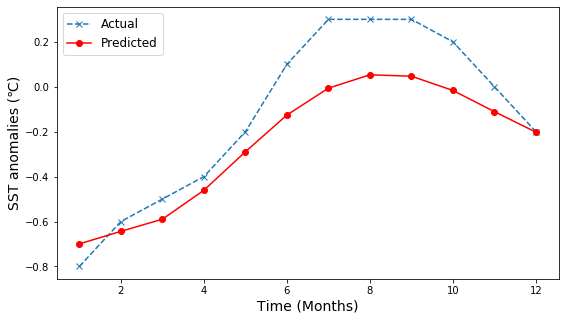

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 


In [ ]:
[-0.69946097,-0.64373022,-0.58964034,-0.46077004,-0.28930514,-0.12585575,-0.00629584,0.05322412,0.04693552,-0.01659007,-0.11084046,-0.20219761]
